In [36]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import sys; sys.path.append('../PGDL/sample_code_submission/')
from internal_rep.matrix_funcs import \
    get_KF_Schatten_norms, \
    compute_complexity, \
    get_df_tau, \
    evalues_from_regions, \
    get_local_rad_bound

In [2]:
def sample_dataset(x, y, n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed(int(time.time()))

    indices = np.random.choice(range(x.shape[0]), size=n_samples, replace=False)
    x = x[indices]
    y = y[indices]
    return x, y

def prepare_mnist_dataset(
    batch_size=64,
    train_sample_size=None,
    test_sample_size=None,
    seed=None,
    shuffle=True,
    shuffle_label_frac=None
):
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()#path='/mnt/ssd3/ronan/tensorflow_datasets/')
    y_train = y_train.astype('int32')
    y_test = y_test.astype('int32')

    if train_sample_size is not None:
        x_train, y_train = sample_dataset(x_train, y_train, int(train_sample_size), seed)
        if shuffle:
            shuffle_indices = np.arange(train_sample_size)
            np.random.seed(seed)
            np.random.shuffle(shuffle_indices)
            x_train = x_train[shuffle_indices]
            y_train = y_train[shuffle_indices]
        if shuffle_label_frac is not None:
            n_shuffle = int(shuffle_label_frac * train_sample_size)
            y_shuffle = y_train[:n_shuffle]
            np.random.seed(seed)
            np.random.shuffle(y_shuffle)
            y_train[:n_shuffle] = y_shuffle

    if test_sample_size is not None:
        x_test, y_test = sample_dataset(x_test, y_test, int(test_sample_size), seed)

    x_train, x_test = tf.cast(x_train, tf.float32) / 255.0, tf.cast(x_test, tf.float32) / 255.0
    print(f"x_train.shape={x_train.shape} y_train={y_train.shape} "
                 f"x_test.shape={x_test.shape} y_test={y_test.shape}")

    shuffle_buffer = 1000
    prefetch_buffer = 1000
    dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # dataset = dataset.shuffle(shuffle_buffer)
    dataset_train = dataset_train.prefetch(prefetch_buffer).batch(batch_size)
    dataset_test = dataset_test.prefetch(prefetch_buffer).batch(batch_size)
    
    return dataset_train, dataset_test # , (x_train, y_train), (x_test, y_test)

## Models

In [3]:
# Source https://github.com/lilianweng/generalization-experiment/blob/master/utils.py
def dense_nn(inputs, layers_sizes, name="fc", reuse=False, output_fn=None,
             dropout_keep_prob=None, training=True):
    with tf.variable_scope(name, reuse=reuse):
        out = inputs
        for i, size in enumerate(layers_sizes):
            if i > 0 and dropout_keep_prob is not None and training:
                # No dropout on the input layer.
                out = tf.nn.dropout(out, keep_prob=dropout_keep_prob)

            out = tf.layers.dense(
                out,
                size,
                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                bias_initializer=tf.constant_initializer(0.0),
                name=name + '_l' + str(i),
                reuse=reuse,
                # Add relu activation only for internal layers.
                activation=tf.nn.relu if i < len(layers_sizes) - 1 else None,
            )

        if output_fn:
            out = output_fn(out)

    return out

In [5]:
def fit_model(model, n_epochs, optimizer, loss_fn, metric, metric_dict={}, label=''):
    @tf.function
    def _train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric
        metric.update_state(y, logits)
        return loss_value

    # @tf.function
    def _test_step(x, y):
        logits = model(x, training=False)
        # Update val metrics
        metric.update_state(y, logits)
        return logits, y

    model_results = defaultdict(list)
    
    for epoch in range(n_epochs):
        losses = []
        for step, (x_batch, y_batch) in enumerate(ds_train):
            loss_value = _train_step(x_batch, y_batch)
            losses.append(loss_value)
        model_results['train_loss'].append(np.mean(losses))
            
        # Display metrics at the end of each epoch.
        train_acc = metric.result()
        metric.reset_states()
        
        model_results['train_accuracy'].append(train_acc)
        
        # Run a validation loop at the end of each epoch.
        logit_list = []
        y_list = []
        for x_batch, y_batch in ds_test:
            logits, y = _test_step(x_batch, y_batch)
            logit_list.append(logits)
            y_list.append(y)
        y_list = tf.concat(y_list, axis=0)
        logit_list = tf.concat(logit_list, axis=0)
        model_results['test_ece'].append(tfp.stats.expected_calibration_error(10, logit_list, y_list))
        
            
        test_acc = metric.result()
        metric.reset_states()
        model_results['test_accuracy'].append(test_acc)
        
        # Get the TRAIN complexity at the end of each epoch
        for label, ds in zip(('train', 'test'), (ds_train, ds_test)):
            internal_rep = []
            for x_batch, y_batch in ds:
                for layer in model.layers[:-1]:
                    x_batch = layer(x_batch)
                internal_rep.append((x_batch.numpy() > 0).astype('bool'))
            internal_rep = np.vstack(internal_rep)
            evalues = evalues_from_regions(internal_rep)
            h_star, h_argmin = get_local_rad_bound(evalues, from_evalues=True)
            model_results[f'h*_{label}'].append(h_star)
            model_results[f'h_argmin_{label}'].append(h_argmin)
            model_results[f'n_activated_regions_{label}'].append(sum(evalues > 0))
        
        # Get the TEST complexity at the end of each epoch

        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Training acc={train_acc:.3f}, Validation acc={test_acc:.3f}")
        
    return model, model_results

## Varying noise proportion

In [85]:
n_units = 30
n_train_sample = 1000

model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),#input_shape=(28, 28)),
    tf.keras.layers.Dense(n_units, activation='relu'),
    tf.keras.layers.Dense(10)
])

shuffle_fracs = [0, 0.2, 0.5, 0.8, 1]

results_dict = {}
for shuffle_frac in tqdm(shuffle_fracs):
    total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10
    
    model = tf.keras.models.clone_model(model_base)
    
    n_epochs = 250
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    ds_train, ds_test = prepare_mnist_dataset(
        train_sample_size=n_train_sample, test_sample_size=10000,
        shuffle_label_frac=shuffle_frac, seed=0)
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    results_dict[shuffle_frac] = model_results

  0%|          | 0/5 [00:00<?, ?it/s]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.369, Validation acc=0.581
Epoch 5: Training acc=0.901, Validation acc=0.855
Epoch 10: Training acc=0.946, Validation acc=0.875
Epoch 15: Training acc=0.967, Validation acc=0.881
Epoch 20: Training acc=0.980, Validation acc=0.882
Epoch 25: Training acc=0.991, Validation acc=0.882
Epoch 30: Training acc=0.995, Validation acc=0.882
Epoch 35: Training acc=0.997, Validation acc=0.882
Epoch 40: Training acc=0.999, Validation acc=0.882
Epoch 45: Training acc=0.999, Validation acc=0.882
Epoch 50: Training acc=1.000, Validation acc=0.882
Epoch 55: Training acc=1.000, Validation acc=0.882
Epoch 60: Training acc=1.000, Validation acc=0.882
Epoch 65: Training acc=1.000, Validation acc=0.882
Epoch 70: Training acc=1.000, Validation acc=0.881
Epoch 75: Training acc=1.000, Validation acc=0.881
Epoch 80: Training acc=1.000, Validation acc=0.881
Epoch 85: Training acc=1.000, Validation acc=

 20%|██        | 1/5 [03:02<12:08, 182.14s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.242, Validation acc=0.447
Epoch 5: Training acc=0.741, Validation acc=0.831
Epoch 10: Training acc=0.778, Validation acc=0.849
Epoch 15: Training acc=0.799, Validation acc=0.851
Epoch 20: Training acc=0.816, Validation acc=0.847
Epoch 25: Training acc=0.831, Validation acc=0.840
Epoch 30: Training acc=0.843, Validation acc=0.831
Epoch 35: Training acc=0.854, Validation acc=0.824
Epoch 40: Training acc=0.869, Validation acc=0.816
Epoch 45: Training acc=0.881, Validation acc=0.811
Epoch 50: Training acc=0.894, Validation acc=0.806
Epoch 55: Training acc=0.908, Validation acc=0.798
Epoch 60: Training acc=0.923, Validation acc=0.793
Epoch 65: Training acc=0.936, Validation acc=0.785
Epoch 70: Training acc=0.947, Validation acc=0.781
Epoch 75: Training acc=0.961, Validation acc=0.777
Epoch 80: Training acc=0.971, Validation acc=0.775
Epoch 85: Training acc=0.977, Validation acc=

 40%|████      | 2/5 [06:08<09:13, 184.43s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.114, Validation acc=0.219
Epoch 5: Training acc=0.465, Validation acc=0.680
Epoch 10: Training acc=0.543, Validation acc=0.759
Epoch 15: Training acc=0.571, Validation acc=0.761
Epoch 20: Training acc=0.606, Validation acc=0.743
Epoch 25: Training acc=0.645, Validation acc=0.730
Epoch 30: Training acc=0.674, Validation acc=0.709
Epoch 35: Training acc=0.704, Validation acc=0.691
Epoch 40: Training acc=0.742, Validation acc=0.676
Epoch 45: Training acc=0.778, Validation acc=0.659
Epoch 50: Training acc=0.797, Validation acc=0.647
Epoch 55: Training acc=0.828, Validation acc=0.634
Epoch 60: Training acc=0.849, Validation acc=0.626
Epoch 65: Training acc=0.865, Validation acc=0.614
Epoch 70: Training acc=0.886, Validation acc=0.609
Epoch 75: Training acc=0.902, Validation acc=0.602
Epoch 80: Training acc=0.917, Validation acc=0.594
Epoch 85: Training acc=0.930, Validation acc=

 60%|██████    | 3/5 [09:12<06:09, 184.61s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.099, Validation acc=0.103
Epoch 5: Training acc=0.267, Validation acc=0.435
Epoch 10: Training acc=0.336, Validation acc=0.493
Epoch 15: Training acc=0.409, Validation acc=0.479
Epoch 20: Training acc=0.462, Validation acc=0.461
Epoch 25: Training acc=0.523, Validation acc=0.439
Epoch 30: Training acc=0.575, Validation acc=0.422
Epoch 35: Training acc=0.633, Validation acc=0.402
Epoch 40: Training acc=0.676, Validation acc=0.387
Epoch 45: Training acc=0.725, Validation acc=0.372
Epoch 50: Training acc=0.750, Validation acc=0.355
Epoch 55: Training acc=0.782, Validation acc=0.347
Epoch 60: Training acc=0.812, Validation acc=0.332
Epoch 65: Training acc=0.845, Validation acc=0.323
Epoch 70: Training acc=0.864, Validation acc=0.317
Epoch 75: Training acc=0.889, Validation acc=0.312
Epoch 80: Training acc=0.899, Validation acc=0.304
Epoch 85: Training acc=0.914, Validation acc=

 80%|████████  | 4/5 [12:18<03:04, 184.93s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.091, Validation acc=0.071
Epoch 5: Training acc=0.278, Validation acc=0.082
Epoch 10: Training acc=0.371, Validation acc=0.085
Epoch 15: Training acc=0.439, Validation acc=0.089
Epoch 20: Training acc=0.499, Validation acc=0.093
Epoch 25: Training acc=0.541, Validation acc=0.092
Epoch 30: Training acc=0.589, Validation acc=0.092
Epoch 35: Training acc=0.631, Validation acc=0.090
Epoch 40: Training acc=0.687, Validation acc=0.094
Epoch 45: Training acc=0.734, Validation acc=0.095
Epoch 50: Training acc=0.769, Validation acc=0.097
Epoch 55: Training acc=0.798, Validation acc=0.099
Epoch 60: Training acc=0.834, Validation acc=0.099
Epoch 65: Training acc=0.852, Validation acc=0.100
Epoch 70: Training acc=0.888, Validation acc=0.101
Epoch 75: Training acc=0.905, Validation acc=0.105
Epoch 80: Training acc=0.920, Validation acc=0.105
Epoch 85: Training acc=0.931, Validation acc=

100%|██████████| 5/5 [15:24<00:00, 184.88s/it]


In [94]:
import pickle
with open('./results_dict_30.pkl', 'wb') as f:
    pickle.dump(results_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

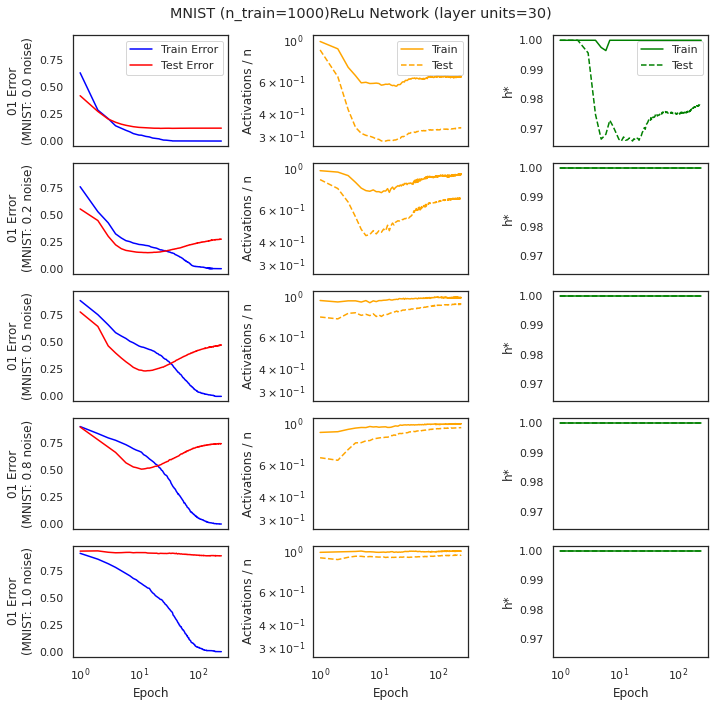

In [93]:
sns.set_context('notebook')
sns.set_style('white')

h_key = 'h*'# 'h_argmin'

keys = [0.0, 0.2, 0.5, 0.8, 1]

n_rows = len(keys)
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 2*n_rows), sharex=True, sharey='col')

for idx, shuffle_frac in enumerate(keys):
    sub_dict = results_dict[shuffle_frac]
    train_error = 1 - np.asarray(sub_dict['train_accuracy'])
    test_error = 1 - np.asarray(sub_dict['test_accuracy'])
    train_loss = np.asarray(sub_dict['train_loss'])
    train_n_regions = np.asarray(sub_dict['n_activated_regions_train']) / n_train_sample
    test_n_regions = np.asarray(sub_dict['n_activated_regions_test']) / 10000
    train_h_stars = np.asarray(sub_dict[h_key + '_train']) * np.sqrt(n_train_sample)
    test_h_stars = np.asarray(sub_dict[h_key + '_test']) * np.sqrt(10000)
    eces = sub_dict['test_ece']

    epochs = np.arange(len(train_error)) + 1

    ax1, ax2, ax3 = axes[idx]
    ax1.plot(epochs, train_error, c='blue', label='Train Error')
    ax1.plot(epochs, test_error, c='red', label='Test Error')
    ax1.set_xscale('log')
    ax1.set_ylabel(f'01 Error\n(MNIST: {shuffle_frac:.1f} noise)')
    
    ax2.plot(epochs, train_n_regions, c='orange', ls='-', label='Train')
    ax2.plot(epochs, test_n_regions, c='orange', ls='--', label='Test')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylabel('Activations / n')

    ax3.plot(epochs, train_h_stars, c='green', ls='-', label='Train')
    ax3.plot(epochs, test_h_stars, c='green', ls='--', label='Test')
    ax3.set_ylabel(h_key)
    ax3.set_xscale('log')

for ax in axes[0]:
    ax.legend(loc='upper right')
for ax in axes[-1]:
    ax.set_xlabel('Epoch')

plt.suptitle(
    f'MNIST (n_train={n_train_sample})' +
    f'ReLu Network (layer units={n_units})')
plt.tight_layout()
plt.show()

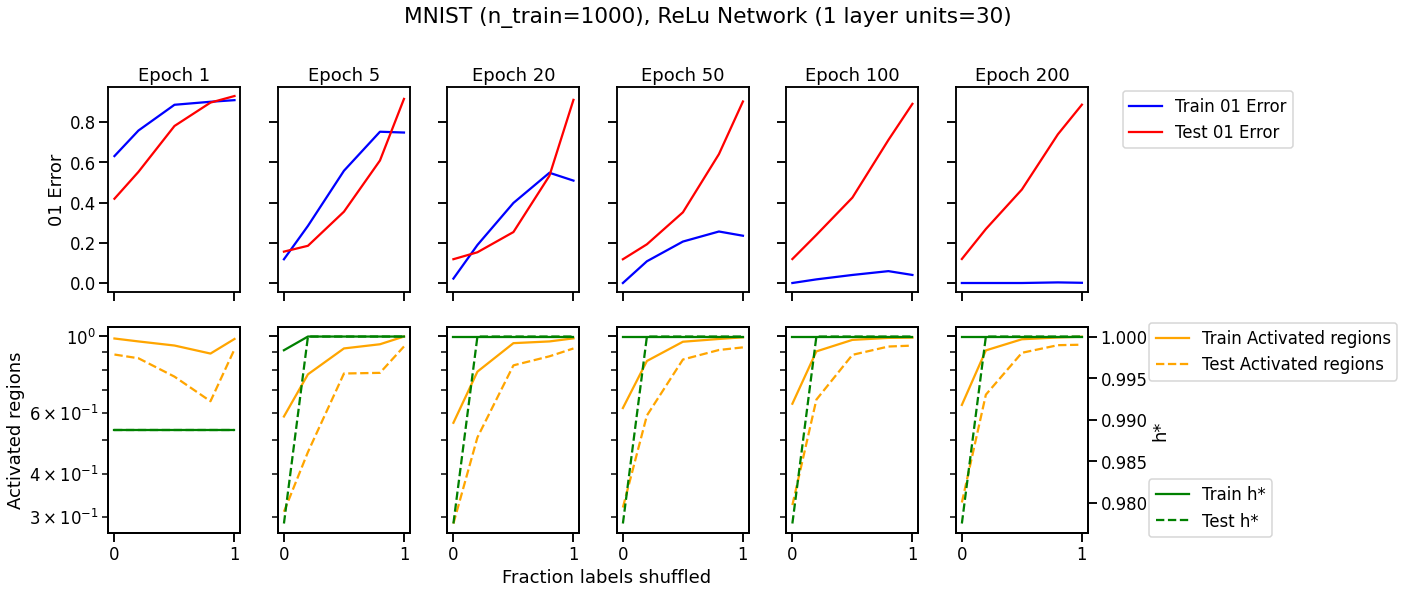

In [89]:
sns.set_context('talk')
h_key = 'h*' # 'h_argmin'

exogenous_vars = list(results_dict.keys())
train_error = 1 - np.asarray([results_dict[k]['train_accuracy'] for k in exogenous_vars])
test_error = 1 - np.asarray([results_dict[k]['test_accuracy'] for k in exogenous_vars])
train_h_stars = np.asarray([results_dict[k][h_key + '_train'] for k in exogenous_vars]) * np.sqrt(n_train_sample)
test_h_stars = np.asarray([results_dict[k][h_key + '_test'] for k in exogenous_vars]) * np.sqrt(10000)
train_regions = np.asarray([results_dict[k]['n_activated_regions_train'] for k in exogenous_vars]) / n_train_sample
test_regions = np.asarray([results_dict[k]['n_activated_regions_test'] for k in exogenous_vars]) / 10000
eces = np.asarray([results_dict[k]['test_ece'] for k in exogenous_vars])

fig, (ax1, ax2) = plt.subplots(2, 6, figsize=(20, 8), sharex=True, sharey='row')

epochs = np.asarray([1, 5, 20, 50, 100, 200]) - 1

for i, ax in enumerate(ax1):
    ax.plot(exogenous_vars, train_error[:, epochs[i]], c='blue', label='Train 01 Error')
    ax.plot(exogenous_vars, test_error[:, epochs[i]], c='red', label='Test 01 Error')
    # ax.legend(loc='lower right')
    # ax.set_xscale('log')
    # ax_twin = ax.twinx()
#     ax_twin.plot(exogenous_vars, eces[:, epochs[i]], c='purple', label='ECE')
#     ax_twin.legend(loc='upper right')
#     if i < len(ax1) - 1:
#         ax_twin.set_yticks([])
    ax.set_title(f'Epoch {epochs[i]+1}')
ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1.02))
ax1[0].set_ylabel('01 Error')
# ax_twin.set_ylabel('ECE (Expected calibration error)')

for i, ax in enumerate(ax2):
    ax.plot(exogenous_vars, train_regions[:, epochs[i]], c='orange', ls='-', label='Train Activated regions')
    ax.plot(exogenous_vars, test_regions[:, epochs[i]], c='orange', ls='--', label='Test Activated regions')
    # ax.legend(loc='lower right')
    # ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(exogenous_vars, train_h_stars[:, epochs[i]], c='green', ls='-', label='Train ' + h_key)
    ax_twin.plot(exogenous_vars, test_h_stars[:, epochs[i]], c='green', ls='--', label='Test ' + h_key)
    # ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
fig.text(0.43, 0, 'Fraction labels shuffled', ha='center')
ax_twin.legend(loc='upper left', bbox_to_anchor=(1.4, 0.3))
ax.legend(loc='lower left', bbox_to_anchor=(1.4, 0.7))
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel(h_key)
ax.set_yscale('log')

plt.suptitle(
    f'MNIST (n_train={n_train_sample}), ReLu Network (1 layer units={n_units})', y=1)
plt.tight_layout()
plt.show()

## More units

In [73]:
n_units = 100
n_train_sample = 1000
n_epochs = 100
shuffle_fracs = [0, 0.2, 0.5, 0.8, 1]

model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),#input_shape=(28, 28)),
    tf.keras.layers.Dense(n_units, activation='relu'),
    tf.keras.layers.Dense(10)
])

results_dict = {}
for shuffle_frac in tqdm(shuffle_fracs):
    total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10
    
    model = tf.keras.models.clone_model(model_base)
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    ds_train, ds_test = prepare_mnist_dataset(
        train_sample_size=n_train_sample, test_sample_size=10000,
        shuffle_label_frac=shuffle_frac, seed=0)
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    results_dict[shuffle_frac] = model_results

  0%|          | 0/5 [00:00<?, ?it/s]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.455, Validation acc=0.660
Epoch 5: Training acc=0.940, Validation acc=0.878
Epoch 10: Training acc=0.977, Validation acc=0.887
Epoch 15: Training acc=0.995, Validation acc=0.891
Epoch 20: Training acc=0.999, Validation acc=0.892
Epoch 25: Training acc=0.999, Validation acc=0.893
Epoch 30: Training acc=1.000, Validation acc=0.893
Epoch 35: Training acc=1.000, Validation acc=0.893
Epoch 40: Training acc=1.000, Validation acc=0.893
Epoch 45: Training acc=1.000, Validation acc=0.894
Epoch 50: Training acc=1.000, Validation acc=0.894
Epoch 55: Training acc=1.000, Validation acc=0.895
Epoch 60: Training acc=1.000, Validation acc=0.895
Epoch 65: Training acc=1.000, Validation acc=0.895
Epoch 70: Training acc=1.000, Validation acc=0.895
Epoch 75: Training acc=1.000, Validation acc=0.895
Epoch 80: Training acc=1.000, Validation acc=0.895
Epoch 85: Training acc=1.000, Validation acc=

 20%|██        | 1/5 [01:23<05:35, 83.98s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.319, Validation acc=0.627
Epoch 5: Training acc=0.777, Validation acc=0.853
Epoch 10: Training acc=0.816, Validation acc=0.860
Epoch 15: Training acc=0.844, Validation acc=0.852
Epoch 20: Training acc=0.877, Validation acc=0.844
Epoch 25: Training acc=0.902, Validation acc=0.836
Epoch 30: Training acc=0.926, Validation acc=0.828
Epoch 35: Training acc=0.955, Validation acc=0.822
Epoch 40: Training acc=0.971, Validation acc=0.818
Epoch 45: Training acc=0.976, Validation acc=0.812
Epoch 50: Training acc=0.979, Validation acc=0.807
Epoch 55: Training acc=0.987, Validation acc=0.805
Epoch 60: Training acc=0.989, Validation acc=0.802
Epoch 65: Training acc=0.992, Validation acc=0.799
Epoch 70: Training acc=0.993, Validation acc=0.798
Epoch 75: Training acc=0.994, Validation acc=0.799
Epoch 80: Training acc=0.995, Validation acc=0.796
Epoch 85: Training acc=0.996, Validation acc=

 40%|████      | 2/5 [02:45<04:07, 82.60s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.163, Validation acc=0.437
Epoch 5: Training acc=0.538, Validation acc=0.785
Epoch 10: Training acc=0.597, Validation acc=0.776
Epoch 15: Training acc=0.660, Validation acc=0.748
Epoch 20: Training acc=0.742, Validation acc=0.716
Epoch 25: Training acc=0.818, Validation acc=0.694
Epoch 30: Training acc=0.870, Validation acc=0.671
Epoch 35: Training acc=0.907, Validation acc=0.658
Epoch 40: Training acc=0.933, Validation acc=0.642
Epoch 45: Training acc=0.948, Validation acc=0.630
Epoch 50: Training acc=0.961, Validation acc=0.622
Epoch 55: Training acc=0.973, Validation acc=0.611
Epoch 60: Training acc=0.982, Validation acc=0.608
Epoch 65: Training acc=0.985, Validation acc=0.601
Epoch 70: Training acc=0.988, Validation acc=0.598
Epoch 75: Training acc=0.991, Validation acc=0.594
Epoch 80: Training acc=0.995, Validation acc=0.590
Epoch 85: Training acc=0.998, Validation acc=

 60%|██████    | 3/5 [04:07<02:44, 82.19s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.094, Validation acc=0.140
Epoch 5: Training acc=0.371, Validation acc=0.570
Epoch 10: Training acc=0.502, Validation acc=0.521
Epoch 15: Training acc=0.604, Validation acc=0.470
Epoch 20: Training acc=0.723, Validation acc=0.433
Epoch 25: Training acc=0.796, Validation acc=0.407
Epoch 30: Training acc=0.861, Validation acc=0.388
Epoch 35: Training acc=0.902, Validation acc=0.376
Epoch 40: Training acc=0.930, Validation acc=0.364
Epoch 45: Training acc=0.957, Validation acc=0.353
Epoch 50: Training acc=0.965, Validation acc=0.346
Epoch 55: Training acc=0.975, Validation acc=0.339
Epoch 60: Training acc=0.982, Validation acc=0.337
Epoch 65: Training acc=0.985, Validation acc=0.333
Epoch 70: Training acc=0.990, Validation acc=0.327
Epoch 75: Training acc=0.995, Validation acc=0.326
Epoch 80: Training acc=0.997, Validation acc=0.323
Epoch 85: Training acc=0.998, Validation acc=

 80%|████████  | 4/5 [05:28<01:21, 81.63s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.099, Validation acc=0.105
Epoch 5: Training acc=0.368, Validation acc=0.095
Epoch 10: Training acc=0.523, Validation acc=0.094
Epoch 15: Training acc=0.649, Validation acc=0.103
Epoch 20: Training acc=0.759, Validation acc=0.110
Epoch 25: Training acc=0.849, Validation acc=0.112
Epoch 30: Training acc=0.902, Validation acc=0.113
Epoch 35: Training acc=0.931, Validation acc=0.114
Epoch 40: Training acc=0.953, Validation acc=0.112
Epoch 45: Training acc=0.968, Validation acc=0.113
Epoch 50: Training acc=0.976, Validation acc=0.115
Epoch 55: Training acc=0.982, Validation acc=0.115
Epoch 60: Training acc=0.986, Validation acc=0.114
Epoch 65: Training acc=0.990, Validation acc=0.115
Epoch 70: Training acc=0.991, Validation acc=0.115
Epoch 75: Training acc=0.992, Validation acc=0.115
Epoch 80: Training acc=0.994, Validation acc=0.115
Epoch 85: Training acc=0.995, Validation acc=

100%|██████████| 5/5 [06:49<00:00, 81.88s/it]


In [95]:
import pickle
with open('./results_dict_100.pkl', 'wb') as f:
    pickle.dump(results_dict_100, f, protocol=pickle.HIGHEST_PROTOCOL)

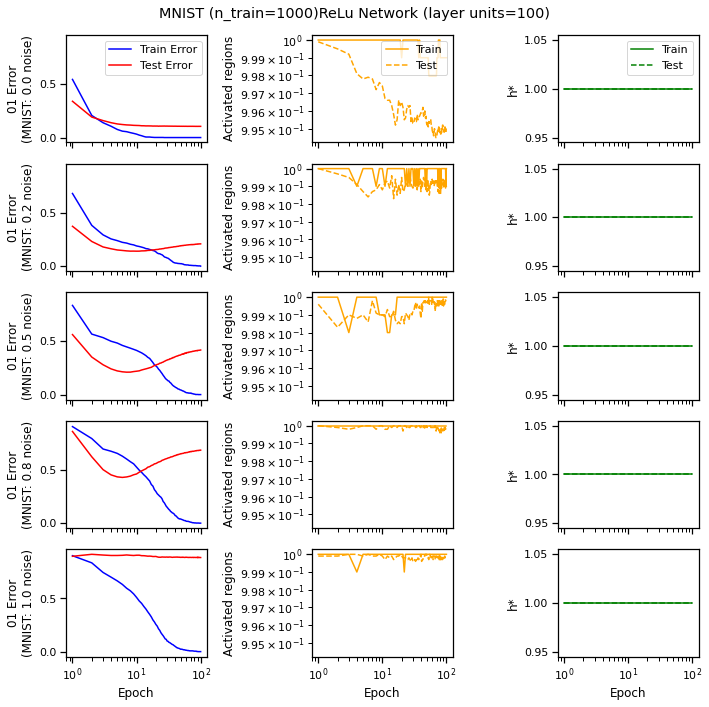

In [80]:
sns.set_context('notebook')

h_key = 'h*'# 'h_argmin'

keys = [0.0, 0.2, 0.5, 0.8, 1]

n_rows = len(keys)
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 2*n_rows), sharex=True, sharey='col')

for idx, shuffle_frac in enumerate(keys):
    sub_dict = results_dict[shuffle_frac]
    train_error = 1 - np.asarray(sub_dict['train_accuracy'])
    test_error = 1 - np.asarray(sub_dict['test_accuracy'])
    train_loss = np.asarray(sub_dict['train_loss'])
    train_n_regions = np.asarray(sub_dict['n_activated_regions_train']) / n_train_sample
    test_n_regions = np.asarray(sub_dict['n_activated_regions_test']) / 10000
    train_h_stars = np.asarray(sub_dict[h_key + '_train']) * np.sqrt(n_train_sample)
    test_h_stars = np.asarray(sub_dict[h_key + '_test']) * np.sqrt(10000)
    eces = sub_dict['test_ece']

    epochs = np.arange(len(train_error)) + 1

    ax1, ax2, ax3 = axes[idx]
    ax1.plot(epochs, train_error, c='blue', label='Train Error')
    ax1.plot(epochs, test_error, c='red', label='Test Error')
    ax1.set_xscale('log')
    ax1.set_ylabel(f'01 Error\n(MNIST: {shuffle_frac:.1f} noise)')
    
    ax2.plot(epochs, train_n_regions, c='orange', ls='-', label='Train')
    ax2.plot(epochs, test_n_regions, c='orange', ls='--', label='Test')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylabel('Activated regions')

    ax3.plot(epochs, train_h_stars, c='green', ls='-', label='Train')
    ax3.plot(epochs, test_h_stars, c='green', ls='--', label='Test')
    ax3.set_ylabel(h_key)
    ax3.set_xscale('log')

for ax in axes[0]:
    ax.legend(loc='upper right')
for ax in axes[-1]:
    ax.set_xlabel('Epoch')

plt.suptitle(
    f'MNIST (n_train={n_train_sample})' +
    f'ReLu Network (layer units={n_units})')
plt.tight_layout()
plt.show()

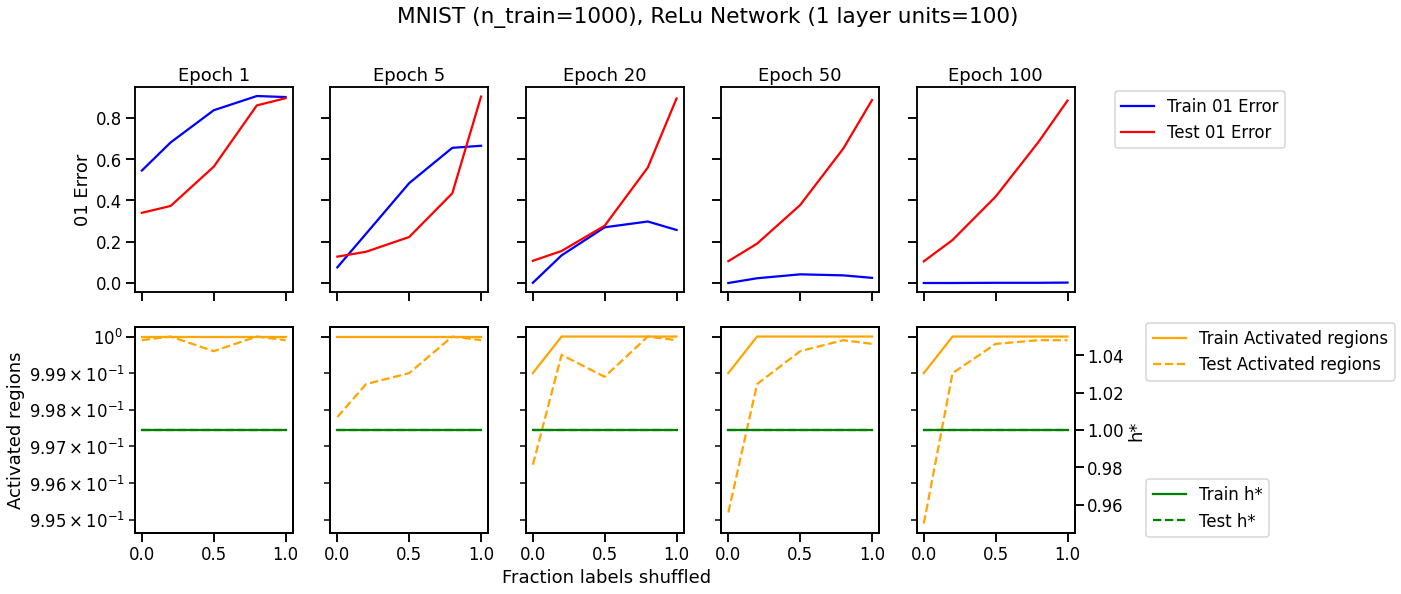

In [82]:
sns.set_context('talk')
h_key = 'h*' # 'h_argmin'

exogenous_vars = list(results_dict.keys())
train_error = 1 - np.asarray([results_dict[k]['train_accuracy'] for k in exogenous_vars])
test_error = 1 - np.asarray([results_dict[k]['test_accuracy'] for k in exogenous_vars])
train_h_stars = np.asarray([results_dict[k][h_key + '_train'] for k in exogenous_vars]) * np.sqrt(n_train_sample)
test_h_stars = np.asarray([results_dict[k][h_key + '_test'] for k in exogenous_vars]) * np.sqrt(10000)
train_regions = np.asarray([results_dict[k]['n_activated_regions_train'] for k in exogenous_vars]) / n_train_sample
test_regions = np.asarray([results_dict[k]['n_activated_regions_test'] for k in exogenous_vars]) / 10000
eces = np.asarray([results_dict[k]['test_ece'] for k in exogenous_vars])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey='row')

epochs = np.asarray([1, 5, 20, 50, 100]) - 1

for i, ax in enumerate(ax1):
    ax.plot(exogenous_vars, train_error[:, epochs[i]], c='blue', label='Train 01 Error')
    ax.plot(exogenous_vars, test_error[:, epochs[i]], c='red', label='Test 01 Error')
    # ax.legend(loc='lower right')
    # ax.set_xscale('log')
    # ax_twin = ax.twinx()
#     ax_twin.plot(exogenous_vars, eces[:, epochs[i]], c='purple', label='ECE')
#     ax_twin.legend(loc='upper right')
#     if i < len(ax1) - 1:
#         ax_twin.set_yticks([])
    ax.set_title(f'Epoch {epochs[i]+1}')
ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1.02))
ax1[0].set_ylabel('01 Error')
# ax_twin.set_ylabel('ECE (Expected calibration error)')

for i, ax in enumerate(ax2):
    ax.plot(exogenous_vars, train_regions[:, epochs[i]], c='orange', ls='-', label='Train Activated regions')
    ax.plot(exogenous_vars, test_regions[:, epochs[i]], c='orange', ls='--', label='Test Activated regions')
    # ax.legend(loc='lower right')
    # ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(exogenous_vars, train_h_stars[:, epochs[i]], c='green', ls='-', label='Train ' + h_key)
    ax_twin.plot(exogenous_vars, test_h_stars[:, epochs[i]], c='green', ls='--', label='Test ' + h_key)
    # ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
fig.text(0.43, 0, 'Fraction labels shuffled', ha='center')
ax_twin.legend(loc='upper left', bbox_to_anchor=(1.4, 0.3))
ax.legend(loc='lower left', bbox_to_anchor=(1.4, 0.7))
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel(h_key)
ax.set_yscale('log')

plt.suptitle(
    f'MNIST (n_train={n_train_sample}), ReLu Network (1 layer units={n_units})', y=1)
plt.tight_layout()
plt.show()